# LAB: Implementing convolutions

In [ ]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/rramosp/2020.deeplearning/master/init.py
from init import init; init(force_download=False)

In [560]:
import sys
if 'google.colab' in sys.modules:
    print ("setting tensorflow version in colab")
    %tensorflow_version 2.x
    %load_ext tensorboard
import tensorflow as tf
tf.__version__

'2.1.0'

In [ ]:
import tensorflow as tf
from time import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from local.lib import mlutils
%matplotlib inline

## observe how we create a `tf.keras.Conv2D` layers and assign it some weights

In [561]:
c = tf.keras.layers.Conv2D(filters=2, kernel_size=(3,3), activation="sigmoid", dtype=tf.float64)
c.get_config()

{'name': 'conv2d_22',
 'trainable': True,
 'dtype': 'float64',
 'filters': 2,
 'kernel_size': (3, 3),
 'strides': (1, 1),
 'padding': 'valid',
 'data_format': 'channels_last',
 'dilation_rate': (1, 1),
 'activation': 'sigmoid',
 'use_bias': True,
 'kernel_initializer': {'class_name': 'GlorotUniform',
  'config': {'seed': None}},
 'bias_initializer': {'class_name': 'Zeros', 'config': {}},
 'kernel_regularizer': None,
 'bias_regularizer': None,
 'activity_regularizer': None,
 'kernel_constraint': None,
 'bias_constraint': None}

In [562]:
[i.shape for i in c.weights]

[]

initialize its weights (filters) by forcing an evaluation 

In [563]:
c(np.random.randint(10, size=(1,7,7,1)).astype(float))
[i.shape for i in c.weights]

[TensorShape([3, 3, 1, 2]), TensorShape([2])]

### let's set by hand some filters

In [564]:
f1 = np.r_[[[-1, 1,-1],[-1, 1,-1], [-1, 1,-1]]]
f2 = np.r_[[[-1,-1,-1],[ 1, 1, 1], [-1,-1,-1]]]

f = np.zeros(c.weights[0].shape)
f[:,:,0,0] = f1
f[:,:,0,1] = f2
print (f[:,:,0,0])
print (f[:,:,0,1])

[[-1.  1. -1.]
 [-1.  1. -1.]
 [-1.  1. -1.]]
[[-1. -1. -1.]
 [ 1.  1.  1.]
 [-1. -1. -1.]]


In [565]:
c.set_weights([f,np.r_[0,0]]) # keep bias as [0,0]

check they are set

In [566]:
c.weights

[<tf.Variable 'conv2d_22/kernel:0' shape=(3, 3, 1, 2) dtype=float64, numpy=
 array([[[[-1., -1.]],
 
         [[ 1., -1.]],
 
         [[-1., -1.]]],
 
 
        [[[-1.,  1.]],
 
         [[ 1.,  1.]],
 
         [[-1.,  1.]]],
 
 
        [[[-1., -1.]],
 
         [[ 1., -1.]],
 
         [[-1., -1.]]]])>,
 <tf.Variable 'conv2d_22/bias:0' shape=(2,) dtype=float64, numpy=array([0., 0.])>]

## and apply the layer to some image

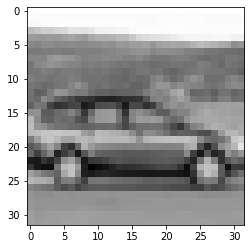

In [567]:
from skimage import io
img = io.imread("local/imgs/sample_img.png")
img = img.reshape(1,*img.shape, 1)
img = (img-np.min(img))/(np.max(img)-np.min(img))
plt.imshow(img[0,:,:,0], cmap=plt.cm.Greys_r);

we are using **valid** padding so activations are smaller than original image

In [568]:
activations = c(img)
activations.shape

TensorShape([1, 30, 30, 2])

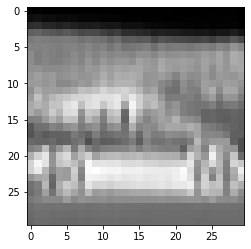

In [569]:
plt.imshow(activations[0,:,:,0], cmap=plt.cm.Greys_r)

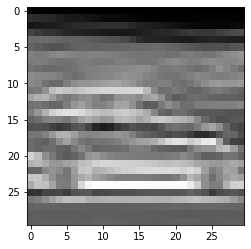

In [570]:
plt.imshow(activations[0,:,:,1], cmap=plt.cm.Greys_r)

## observe how activations pixels are computed

In [571]:
activations[0,:5,:5,1]

<tf.Tensor: shape=(5, 5), dtype=float64, numpy=
array([[0.04987202, 0.04863436, 0.04742587, 0.04702942, 0.04644065],
       [0.11690962, 0.11199884, 0.10726928, 0.1039408 , 0.09487553],
       [0.08045926, 0.0854857 , 0.08899314, 0.08971003, 0.09525451],
       [0.14110197, 0.12975986, 0.12106548, 0.12013108, 0.11287809],
       [0.19837595, 0.20048595, 0.19978076, 0.19558867, 0.18942595]])>

three first pixels in the first row

In [572]:
sigmoid = lambda x: 1/(1+np.exp(-x))
linear  = lambda x: x
print (sigmoid((img[0,:3,:3,:]  * f[:,:,:,1]).sum()))
print (sigmoid((img[0,:3,1:4,:] * f[:,:,:,1]).sum()))
print (sigmoid((img[0,:3,2:5,:] * f[:,:,:,1]).sum()))


0.04987202016028013
0.04863435579977209
0.04742587317756678


observe the shapes of filters and activations to make sense of the indices

In [573]:
img.shape, f.shape, activations.shape

((1, 32, 32, 1), (3, 3, 1, 2), TensorShape([1, 30, 30, 2]))

# TASK 1: Do the convolution by hand in a set of for loops

complete the following function. its parameters:

- `img`: the images, an array of size [1,y,x,k], where:
    - `1`: you will be receiving only one image
    - `x`, `y`: the size of the image
    - `k` : the number of channels
    
- `f`: the filters, an array of size [fy,fx,k,n], where:
    - `fx`, `fy`: the size of the filters
    - `k` : the number of channels (**must be the same as in images**)
    - `n`: the number of filters
- `activation`: the activation function to use (such as `sigmoid` or `linear` above)

In [ ]:
def convolution_byhand(img, f, activation=sigmoid):
    assert f.shape[2]==img.shape[3]
    fy = f.shape[0]
    fx = f.shape[1]
    r = np.zeros( (1, img.shape[1]-fy+1, img.shape[2]-fx+1, f.shape[3] ))
    ... # YOUR CODE HERE
    return r

In [ ]:
r = convolution_byhand(img, f)

check your answer

In [ ]:
plt.figure(figsize=(7,3))
plt.subplot(121); plt.imshow(r[0,:,:,0], cmap=plt.cm.Greys_r); plt.title("your convolution")
plt.subplot(122); plt.imshow(activations[0,:,:,0], cmap=plt.cm.Greys_r); plt.title("keras convolution")

In [ ]:
plt.figure(figsize=(7,3))
plt.subplot(121); plt.imshow(r[0,:,:,1], cmap=plt.cm.Greys_r); plt.title("your convolution")
plt.subplot(122); plt.imshow(activations[0,:,:,1], cmap=plt.cm.Greys_r); plt.title("keras convolution")

# Task 2: Do the convolution by hand in 'one shot'

We will prepare images to do the convolution with one dot product operation for each filter and each image. This will use more memory but will increase performance.

For instance, assume we have the following 1x8x6x1 images (only one image, one channel) and 2x3x1x2 filters (one channel, two filters)

In [ ]:
img = np.r_[[9, 4, 9, 6, 7, 1, 2, 2, 8, 0, 8, 6, 8, 6, 5, 5, 1, 4, 3, 4, 4, 4,
             3, 6, 5, 1, 7, 9, 1, 4, 0, 3, 1, 4, 3, 5, 1, 5, 5, 4, 9, 6, 3, 2,
             8, 9, 0, 6]].reshape(1,8,6,1)
f = np.r_[[6, 7, 8, 5, 2, 9, 6, 4, 9, 7, 9, 7]].reshape(2,3,1,2)
print ("images", img.shape)
print (img[0,:,:,0])
print ("--")
print ("filters", f.shape)
print (f[:,:,0,0])
print (f[:,:,0,1])

### step 1: complete the following function to prepare the images

where:

- `img` is the images array (assume we only have one image)
- `fy` and `fx` are the filter dimensions (2,3 in the example just above)

if called with `img` and `f` above you shoud get the following output

    > pimg = prepare_img(img, *f.shape[:2])
    > pimg
    
    array([[[[9., 4., 9., 2., 2., 8.],
             [4., 9., 6., 2., 8., 0.],
             [9., 6., 7., 8., 0., 8.],
             [6., 7., 1., 0., 8., 6.]],

            [[2., 2., 8., 8., 6., 5.],
             [2., 8., 0., 6., 5., 5.],
             [8., 0., 8., 5., 5., 1.],
             [0., 8., 6., 5., 1., 4.]],

            [[8., 6., 5., 3., 4., 4.],
             [6., 5., 5., 4., 4., 4.],
             [5., 5., 1., 4., 4., 3.],
             [5., 1., 4., 4., 3., 6.]],

            [[3., 4., 4., 5., 1., 7.],
             [4., 4., 4., 1., 7., 9.],
             [4., 4., 3., 7., 9., 1.],
             [4., 3., 6., 9., 1., 4.]],

            [[5., 1., 7., 0., 3., 1.],
             [1., 7., 9., 3., 1., 4.],
             [7., 9., 1., 1., 4., 3.],
             [9., 1., 4., 4., 3., 5.]],

            [[0., 3., 1., 1., 5., 5.],
             [3., 1., 4., 5., 5., 4.],
             [1., 4., 3., 5., 4., 9.],
             [4., 3., 5., 4., 9., 6.]],

            [[1., 5., 5., 3., 2., 8.],
             [5., 5., 4., 2., 8., 9.],
             [5., 4., 9., 8., 9., 0.],
             [4., 9., 6., 9., 0., 6.]]]])
             
    > pimg.shape
    
    (1, 7, 4, 6)
    
    
observe that:

- resulting images after convolution with any filter will have size 7x4
- the resulting structure `img` has at each pixel (in the 7x4 grid) a vector of six elements associated with it.
- this vector is the flattened contents of 2x3x1 image fragment located at that pixel that would by multiplied element by element by any filter located at that pixel during the convolution.
- the first row in `pimg` corresponds to the flattened 2x3 fragment located at the top left corner of `img`
- the second row contains the 2x3 fragment after shifting one pixel to the right.
- the [`np.flatten`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.flatten.html) operation will surely be useful for you.

In [ ]:
def prepare_img(img, fy, fx):
    r = np.zeros( (1, img.shape[1]-fy+1, img.shape[2]-fx+1, fy*fx*img.shape[3] ))
    ... # YOUR CODE HERE
    return r

In [ ]:
pimg = prepare_img(img, *f.shape[:2])
print (pimg.shape)
pimg

### step 2: use the prepared images to do the convolution  in a single `.dot` operation


complete the following function so that:

- you do the convolution of one image (`i`) and one filter (`j`) with one `.dot` operation in **one single line of code**.
- you apply the corresponding activation function

In [ ]:
def oneshot_convolution(pimg, f, activation=sigmoid):
    r = np.zeros((*pimg.shape[:-1], f.shape[3]))
    for i in range(pimg.shape[0]):
        for j in range(f.shape[3]):
            r[i,:,:,j] = ... # YOUR CODE HERE
    return r

check your solution against your previous implementation

In [ ]:
k1 = oneshot_convolution(pimg, f, activation=sigmoid)
k2 = convolution_byhand(img, f, activation=sigmoid)
np.allclose(k1, k2)

In [ ]:
k1 = oneshot_convolution(pimg, f, activation=linear)
k2 = convolution_byhand(img, f, activation=linear)
np.allclose(k1, k2)

check your solution against keras

In [ ]:
c = tf.keras.layers.Conv2D(filters=f.shape[3], 
                           kernel_size=f.shape[:2], 
                           activation="linear", dtype=tf.float64)
c(img.astype(float))
c.set_weights((f, np.r_[0,0]))

In [ ]:
np.alltrue(c(img.astype(float)).numpy()==k2)